## Imports

In [186]:
import numpy as np
import generator as g
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from utils import plots
import matplotlib.pyplot as plt
import statistics as st

%matplotlib inline

## Funções de Limiares

Podem ser utilizada na predição caso os dados não sejam normalizados para saída do problema

In [139]:
same = lambda x: x
# tupla(x,limit)
threshold = lambda x: np.where(x[0]>x[1], 1, 0) 

## Funções de Ativação

Todas as funções de ativação possíveis para rede neural deste notebook

In [140]:
# Sigmoid: saída entre [0,1]
def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

In [141]:
# Tangente Hiperbólica: saída entre [-1,1]
def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

In [142]:
# Retificadora (Relu): saída 0 caso entrada seja negativa e maior que 1 caso contrário
def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

In [143]:
# Degrau: saída 0 se menor que 0 e saída 1 caso contrário
def step(x,derivative=False):
    if derivative:
        return np.where(x>0,1,1)
    return np.where(x>0,1,0)

In [144]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

## Funções auxiliares

In [145]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

In [146]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

## Funções de custo

In [147]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

In [148]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

In [149]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

## Questões

*1) A representação de uma determinada mensagem digital ternária, isto é formada por três bits,
forma um cubo cujos vértices correspondem a mesma representação digital. Supondo que ao
transmitirmos esta mensagem a mesma possa ser contaminada por ruído formado em torno de
cada vértice uma nuvem esférica de valores aleatórios com raio máximo é 0.1. Formule este
problema como um problema de classificação de padrões e treine uma rede de Perceptron de
Rosenblatt (Perceptron de camada única) para atuar como classificador/decodificador. Para
solução do problema defina antes um conjunto de treinamento e um conjunto de validação.
Dica: O problema pode ser formulado como um problema de classificação de 8 padrões
diferentes, sendo que cada padrão representa um vértice do cubo.*

In [151]:
# entradas
x,y = g.data_1A1(500,dtype='train')
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=100, stratify=y, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(400, 3) (100, 3) (400, 8) (100, 8)


In [152]:
class Sequencial:
    def __init__(self):
        self.learning_rate = 0.02
        self.w = np.random.random((8, 3))-0.5
        self.b = np.zeros(8)
        self.history = { 'errors': [], 'epoch': [] }

    def forward(self, x_i):
        y = np.dot(x_i, self.w.T) + self.b
        return step(y)

    def fit(self, x,y, epochs=100):
        for e in range(epochs):
             for x_i, y_i in zip(x,y):
                x_i =  x_i.reshape(1, x.shape[1])
                y_pred = self.forward(x_i)
                error = y_i-y_pred
                # log
                self.history['errors'].append(np.sum(np.where(error!=0,1,0)))
                self.history['epoch'].append(e)
                self.w = self.w + self.learning_rate*np.dot(error.T, x_i)
                self.b = self.b + self.learning_rate*error[0]

    def predict(self, x_val):
        y_pred = []
        for x in x_val:
            x_i =  x.reshape(1, x_val.shape[1])
            y_pred.append(self.forward(x_i)[0])
        return np.array(y_pred)

w: [[-0.01119218 -0.10827005 -0.09630752]
 [-0.10784286 -0.25431328  0.2105608 ]
 [-0.21665327  0.04468781 -0.04140212]
 [-0.48591402  0.2160397   0.01993266]
 [ 0.04615779 -0.03828374 -0.05932432]
 [ 0.25154313 -0.4148832   0.20631758]
 [ 0.17050017  0.05418491 -0.02075995]
 [ 0.12251686  0.03179468  0.16033516]]
b: [  6.93889390e-18  -1.40000000e-01  -2.00000000e-02  -2.20000000e-01
  -2.00000000e-02  -2.80000000e-01  -2.20000000e-01  -3.00000000e-01]
accurancy:  1.0


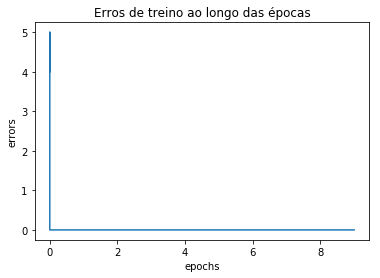

In [153]:
one = Sequencial()
one.fit(x_train, y_train, epochs=10)

print('w:', one.w)
print('b:', one.b)
print('accurancy: ', accuracy_score(y_val, one.predict(x_val)))

plt.title("Erros de treino ao longo das épocas")
plt.xlabel("epochs")
plt.ylabel("errors")
plt.plot(one.history['epoch'],one.history['errors'])
plt.show()

*2) Implemente uma rede perceptron de múltiplas camadas treinando-a com os seguintes
algoritmos:*

*- Algoritmo da retropropagação em modo estocástico usando a regra delta;*

*- Algoritmo da retropropagação em modo por lote usando a regra delta;*

*- Algoritmo da retropropagação usando a regra delta com termo do momento;*


In [13]:
class Layer:
    def __init__(self, input_dim, output_dim, activation=step, use_bias=True):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.bias = np.random.randn(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.input_dim = input_dim
        self.use_bias = use_bias
        self._dweights, self._dbias, self._prev_dweights = None, None, 0.0

In [183]:
class NeuralNetwork:
    def __init__(self, cost_func=mse, learning_rate=1e-3, momentum=0.0):
        self._layers = []
        self.cost_func = cost_func
        self._learning_rate = learning_rate
        self.momentum = momentum
        self.history = { 'errors': [], 'epoch': [] }
    
    def __backpropagation(self, y,y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        self.history['errors'].append(last_delta)
            
        for layer in reversed(self._layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer.dweights = np.dot(dactivation.T, layer.input)
            layer.dbias = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self._layers):
            layer._prev_dweights = -self._learning_rate*layer.dweights + self.momentum*layer._prev_dweights
            layer.weights = layer.weights + layer._prev_dweights
            layer.biases = layer.bias - self._learning_rate*layer.dbias
    
    def __forward(self, x):
        self._layers[0].input = x
        for current_layer, next_layer in zip(self._layers, self._layers[1:] + [Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.bias
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self._layers[-1]._activ_out

    def add(self, layer):
        self._layers.append(layer)
    
    def evaluate(self,y_pred, y, func=same, dtype=int):
        score = 0
        total = 100.0/y.shape[0]
        # mesmo tipo de saida
        y_pred = y_pred.astype(dtype)
        y = y.astype(dtype)

        for y_i, y_pred_i in zip(y,y_pred):
            y_pred_i = func(y_pred_i)
            if np.array_equal(y_i,y_pred_i):
                score+=1
        return score*total

    def fit(self, X=None, Y=None, epochs=1, batch_size=None, verbose=False):
        batch_size = X.shape[0] if batch_size is None else batch_size
        n_batches = X.shape[0] // batch_size
        
        for step in range(epochs+1):
            # treino cada batch
            for batch in range(n_batches):
                offset = batch_size * batch
                # conjunto de treinamento por batch
                X_batch, Y_batch = X[offset:offset+batch_size], Y[offset:offset+batch_size]
                y_pred = self.__forward(X)
                self.__backpropagation(Y, y_pred)
                self.history['epoch'].append(batch)
            
    def get_learning_rate(self):
        return self._learning_rate

    def get_weights(self):
        return self._layers[-1].weights, self._layers[-1].bias

    def predict(self, X, verbose=False):
        return self.__forward(X)

### Testes

In [184]:
x,y = g.data_1A1(500,dtype='train')
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=100, stratify=y, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(400, 3) (100, 3) (400, 8) (100, 8)


In [191]:
D_in, D_out = x_train.shape[1], y_train.shape[1]
model = NeuralNetwork(momentum=0.9)
model.add(Layer(input_dim=D_in, output_dim=D_out, activation=step))
model.add(Layer(input_dim=8, output_dim=8, activation=step))
model.fit(x_train, y_train, batch_size=20, epochs=100, verbose=False)

w,b = model.get_weights()
y_pred = model.predict(x_val, verbose=False)
accurancy = model.evaluate(y_pred, y_val, func=same)

print('w:', w)
print('b:', b)
print('Accurancy: {0:.1f}%'.format(accurancy))

w: [[ 0.83376695 -2.75539687 -0.08295406  0.84040748 -2.07869955 -0.52508605
  -0.42708238 -0.46320234]
 [ 0.98191399 -1.48258841  0.99639271 -0.58174057 -2.52335692 -1.09364555
  -2.30982803  0.09360025]
 [-1.13378435 -4.38238011  1.8583659  -1.9210655  -0.3714973   0.98490294
  -1.21687483 -1.81587643]
 [ 0.9680998  -0.90394963 -1.09591646 -0.19740022  0.86578099 -1.0969256
  -2.04896575 -0.63287773]
 [-2.84300134 -1.40300881 -2.00121289  2.06540544 -2.45785348  1.22980033
   0.11018067  1.57985953]
 [-0.14150216  0.99954978 -0.29687938 -1.38203724 -2.27654871 -3.65738278
   0.89232191  0.05297119]
 [-1.50719026 -2.4375438  -1.67347063 -1.73613835  0.49273883 -0.29686518
   2.70664346  0.54352083]
 [-2.48164552  1.1177177  -2.45069806 -2.46413108  0.00603959 -1.50293439
  -3.02071437 -2.42012416]]
b: [[-0.43668638  0.58216012  0.34633851 -0.31494077  0.71400229 -1.78254849
  -1.82339675  0.67498865]]
Accurancy: 100.0%


In [192]:
accuracy_score(y_val, y_pred)

1.0

*3) Usando algoritmos implementados na questão 2, aproxime as funções abaixo. Compare os
resultados com as curvas exatas, para o caso dos itens b e c e apresente para cada caso a
curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação. Faça uma análise comparativa sobre a convergência de cada um
dos algoritmos. *

*a) **a função lógica XOR** *

In [67]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


Predições:
[[ 0.28995978]
 [ 0.56653937]
 [ 0.57108215]
 [ 0.45964344]]


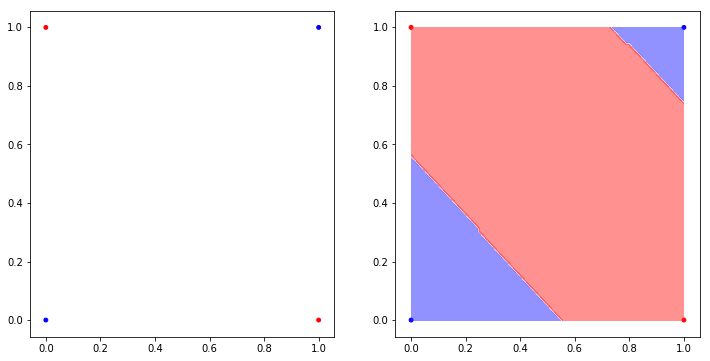

In [79]:
D_in, D_out = x.shape[1], y.shape[1]
model = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-1)
model.add(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
model.add(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

model.fit(x, y, epochs=1000)
y_pred = model.predict(x)
accurancy = model.evaluate(y, y_pred, func=same)

print('Predições:', y_pred, sep='\n')
plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=model, threshold=0.5, cmap='bwr')

*b) **f(x) = sen(xπ)/xπ** 0 ≤ x ≤ 4*

In [203]:
x_train = []
y_train = []

for line in open('../data/data_x-3b.txt', 'r').readlines():
    x_train.append([float(num) for num in line.split(',')])

for line in open('../data/data_y-3b.txt', 'r').readlines():
    y_train.append([float(num) for num in line.split(',')])

x_train = np.array(x_train[:int(len(x_train) * 0.8)])
y_train = np.array(y_train[:int(len(y_train) * 0.8)])

# dados de validação
x_val = np.array(x_train[int(len(x_train) * 0.8):])
y_val = np.array(y_train[int(len(y_train) * 0.8):])

print(x_train.shape, y_train.shape)

(4000, 1) (4000, 1)


In [204]:
D_in, D_out = x_train.shape[1], y_train.shape[1]
model = NeuralNetwork(learning_rate=0.001)
model.add(Layer(input_dim=D_in, output_dim=10, activation=sigmoid))
model.add(Layer(input_dim=10, output_dim=10, activation=tanh))
model.add(Layer(input_dim=10, output_dim=D_out, activation=sigmoid))

model.fit(x_train, y_train, epochs=100)
y_pred = model.predict(x_val)
accurancy = model.evaluate(y_val, y_pred, func=same)

print('Accurancy: {0:.1f}%'.format(accurancy))

Accurancy: 100.0%


*4) Considere um problema de classificação de padrões constituído de oito padrões. A
distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no
círculo um losango também centrado na origem e com lados iguais a raiz de 2. Os dados das
classe C1, C2, C3, C4 corresponde aos quatro setores do losango e as outras quatro classes
correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar
aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto
de treinamento e um conjunto de validação. Treine uma rede perceptron para classificar os
padrões associados a cada uma das classes. Verifique o desempenho do classificador usando
o conjunto de validação e calculando a matriz de confusão.*

In [80]:
x = np.loadtxt('../data/04_x.txt', delimiter=',')
y = np.loadtxt('../data/04_y.txt', delimiter=',').reshape(-1,1)
x.shape, y.shape

((7796, 2), (7796, 1))

In [81]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse=False)
y_oh = onehot.fit_transform(y)
y_oh

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [93]:
D_in, D_out = x.shape[1], y_oh.shape[1]

model = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
model.add(Layer(input_dim=D_in, output_dim=20, activation=linear))
model.add(Layer(input_dim=20, output_dim=D_out, activation=linear))

model.fit(X=x, Y=y_oh, epochs=5000, verbose=100)

In [94]:
y_pred = model.predict(x).argmax(axis=1)

print('Matriz de de confusão:\n', confusion_matrix(y, y_pred))
accuracy_score(y, y_pred)

Matriz de de confusão:
 [[1251    0    2    0    0    0    0    0]
 [   0 1242    0    2    0    0    0    0]
 [   0    0 1224    3    0    0    9    0]
 [   0    1    0 1283    0    0    0    1]
 [   4    0    0    0  668    0    0    0]
 [   0    9    0    0    0  683    0    0]
 [   0    0    0    0    0    0  705    0]
 [   0    0    0    0    0    0    0  709]]


0.99602360184710104

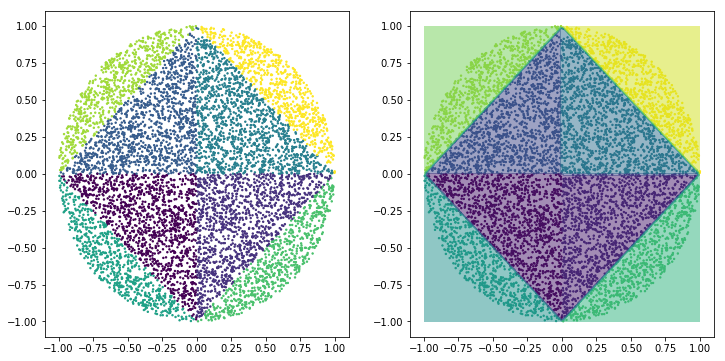

In [95]:
plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=model, s=2)

*5) Utilize a rede neural perceptron de múltiplas camadas para fazer a predição de um passo, até predição de três passos, da série temporal . Avalie o desempenho mostrando para cada caso os erros de predição. 
Dica: Para auxiliar na resolução desse problema você pode usar K entradas (por exemplo, K=10), que correspondem a K passos anteriores a n: x(n-1), x(n-2),..., x(n-K), e deve fazer a
predição dos valores x(n+1), x(n+2) e x(n+3).*

In [154]:
x = np.linspace(-5, 5, 1000).reshape(-1, 1)
y = np.sin(x + np.sin(x)**2).reshape(-1, 1)

In [165]:
D_in, D_out = x.shape[1], y.shape[1]

model = NeuralNetwork(cost_func=mse, learning_rate=1e-4)
model.add(Layer(input_dim=D_in, output_dim=20, activation=tanh))
model.add(Layer(input_dim=20, output_dim=30, activation=tanh))
model.add(Layer(input_dim=30, output_dim=30, activation=tanh))
model.add(Layer(input_dim=30, output_dim=D_out, activation=linear))

model.fit(x, y, epochs=3000, verbose=300)

/home/alvesmarcos/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/alvesmarcos/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


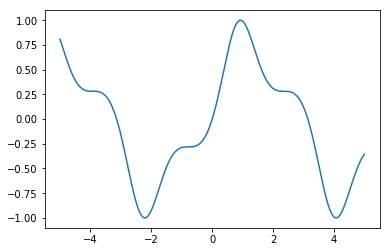

In [163]:
y_pred = model.predict(x)
plt.plot(x, y)
plt.plot(x, y_pred, c='green')